In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import dem_functions as df
import bikeability_functions as bf
import contextily as cx
import pandas as pd

In [10]:
def dem_features(dem):
    dem['frac_pop_nonwhite'] = (dem['total_pop']-dem['total_pop_white'])/dem['total_pop']
    dem['frac_below_poverty'] = dem['below_poverty']/dem['total_pop']
    dem['frac_no_car'] = dem['zero_vehicles']/dem['total_workers']

def quint_curves(G,quant_of_int,var,betas=np.linspace(0.01,10,200)):
    var_low = bf.compute_bikeability_curves(G,quant_of_int[var][0])
    var_high = bf.compute_bikeability_curves(G,quant_of_int[var][1])
    
    curve_1=bf.network_wide_bikeability_curve(betas, var_low)
    curve_2=bf.network_wide_bikeability_curve(betas, var_high)
    
    return curve_1,curve_2

In [2]:
def load_sf_data():
    acs_vars = {'B02001_001E':'total_pop','B02001_002E':'total_pop_white',
                'B19013_001E':'median_hh_income','B06012_002E':'below_poverty',
                'B08014_001E':'total_workers','B08014_002E':'zero_vehicles'}

    G_SF = bf.load_graph('data/V2_SF_coarse_graph_cluster')
    dem_SF = df.get_dem('San Francisco,CA',acs_vars)

    dem_features(dem_SF)

    return G_SF, dem_SF

In [ ]:
def calc_metrics(G, dem_SF, total_length_added, num_cc) -> pd.DataFrame:
    betas = np.linspace(0.01,10,200)
    curves_SF = bf.compute_bikeability_curves(G, G.nodes(), dest='all')
    user_dict_SF = bf.network_wide_bikeability_curve(betas, curves_SF)

    keys = ['frac_pop_nonwhite','frac_below_poverty','median_hh_income','frac_no_car']
    quant_of_int = df.all_quants(keys, dem_SF)
    nonwhite_low, nonwhite_high = quint_curves(G,quant_of_int,'frac_pop_nonwhite')
    poverty_low, poverty_high = quint_curves(G,quant_of_int,'frac_below_poverty')
    income_low, income_high = quint_curves(G,quant_of_int,'median_hh_income')
    carless_low, carless_high = quint_curves(G,quant_of_int,'frac_no_car')
    
    new_row = {'length_added_bikelanes': total_length_added, 
        'number_cc': num_cc,
        'overall_score': bf.calc_elbow(user_dict_SF), 
        'nonwhite_high': bf.calc_elbow(nonwhite_high),
        'nonwhite_low': bf.calc_elbow(nonwhite_low),
        'poverty_high': bf.calc_elbow(poverty_high),
        'poverty_low': bf.calc_elbow(poverty_low),
        'income_high': bf.calc_elbow(income_high),
        'income_low': bf.calc_elbow(income_low),
        'carless_high': bf.calc_elbow(carless_high),
        'carless_low': bf.calc_elbow(carless_low)}

    return pd.DataFrame([new_row])

In [85]:
G, dem = load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [86]:
# isolate bike network
G_bikelanes = nx.DiGraph()  # graph of all bikelanes
G_bikelanes.add_nodes_from(G.nodes(data=True))

# create bikelane and potential bikelane networks
for start_node, end_node, data in G.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

In [87]:
import yan_helper_functions as yhf
G, dem = yhf.load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [88]:
G_bikelanes.edges(data=True)

OutEdgeDataView([('035100', '035300', {'distance': 1537.7359999999999}), ('035201', '035400', {'distance': 2473.947444444444}), ('980300', '045100', {'distance': 43.136}), ('980300', '030101', {'distance': 326.54425000000003}), ('980300', '032601', {'distance': 31.7485}), ('980300', '045200', {'distance': 130.74312500000002}), ('980300', '047901', {'distance': 561.429}), ('980300', '047702', {'distance': 522.2190714285715}), ('980300', '016500', {'distance': 1170.8032500000002}), ('980300', '032700', {'distance': 1232.7576315789474}), ('980300', '047600', {'distance': 298.16866666666664}), ('980300', '047801', {'distance': 162.516}), ('042700', '042800', {'distance': 1340.0294999999999}), ('980200', '047901', {'distance': 533.01635}), ('980200', '042800', {'distance': 1313.9995}), ('047801', '980300', {'distance': 162.51600000000002}), ('042800', '042700', {'distance': 1340.0295}), ('042800', '980200', {'distance': 1313.9995000000004}), ('030202', '030101', {'distance': 401.84475}), ('

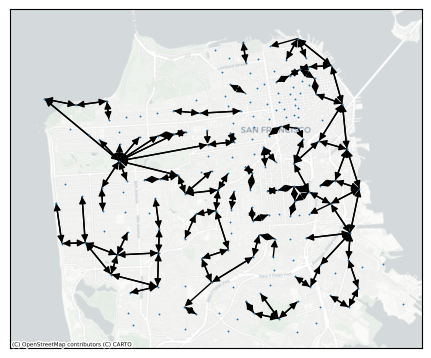

In [91]:
plt.style.use("seaborn-v0_8-paper")
fig, ax = plt.subplots()

coords = [nx.get_node_attributes(G, "x"), nx.get_node_attributes(G, "y")]
node_pos = {}

for k in coords[0].keys():
    node_pos[k] = tuple(d[k] for d in coords)

nx.number_strongly_connected_components(G_bikelanes)

# nx.draw_networkx_edges(G_bikelanes, pos=node_pos, arrowsize=6.6, width=0.66, ax=ax)
nx.draw_networkx(G_bikelanes, pos=node_pos, node_size=1, with_labels=False, ax=ax)
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, attribution_size=4)

In [18]:
# test
G, dem = load_sf_data()

Matched: San Francisco,CA to San Francisco city within layer Incorporated Places


c:\Users\ckaz3\Documents\Academics\College\cycling-equity-master\cycling-equity-master\dem_functions.py:8: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  dem = acs.from_place(place,level='tract',place_type='Incorporated Place',variables=list(acs_vars.keys()))


In [19]:
G_bikelanes = nx.DiGraph()  # graph of all bikelanes
G_bikelanes.add_nodes_from(G.nodes(data=True))
G_potential_bikelanes = (
    nx.DiGraph()
)  # graph of all potential bikelanes (i.e., roads and stroads)
G_potential_bikelanes.add_nodes_from(G.nodes(data=True))

# create bikelane and potential bikelane networks
for start_node, end_node, data in G.edges(data=True):
    if not np.isnan(data["distance"][0]):
        G_bikelanes.add_edge(start_node, end_node, distance=data["distance"][0])

    G_potential_bikelanes.add_edge(
        start_node, end_node, distance=np.nanmin(data["distance"])
    )

In [23]:
G.edges(data=True)

OutMultiEdgeDataView([('035202', '035100', {'geometry': <LINESTRING (-13637321.898 4545774.198, -13636543.199 4545243.323)>, 'distance': [nan, 1124.1042918552037, 1192.9023120775787, 1178.1292540322581], 'discomfort': [0, 370.95441631221723, 787.315525971202, 1178.1292540322581]}), ('035202', '035201', {'geometry': <LINESTRING (-13637321.898 4545774.198, -13637722.492 4544935.834)>, 'distance': [nan, 977.2380546558705, 963.6230948540706, 1068.7725846774192], 'discomfort': [0, 322.48855803643727, 635.9912426036866, 1068.7725846774192]}), ('035202', '980300', {'geometry': <LINESTRING (-13637321.898 4545774.198, -13634847.192 4546833.209)>, 'distance': [nan, 632.8253974358975, 3675.2939067891875, 5215.452049853374], 'discomfort': [0, 208.83238115384617, 2425.6939784808637, 5215.452049853374]}), ('035100', '035202', {'geometry': <LINESTRING (-13636543.199 4545243.323, -13637321.898 4545774.198)>, 'distance': [nan, 1126.435567032967, 1198.7404889663183, 1190.5645940446648], 'discomfort': [0

In [30]:
nx.number_strongly_connected_components(G_bikelanes)

91

In [31]:
import pandas as pd
pd.read_csv("l2c_strong.csv")

,Unnamed: 0,length_added_bikelanes,number_cc,overall_score,nonwhite_high,nonwhite_low,poverty_high,poverty_low,income_high,income_low,carless_high,carless_low
0,0,0.000000,91,3.481880,3.367172,3.808703,2.318071,4.283296,4.505875,2.102802,2.081167,4.109593
1,0,10283.814369,82,3.875432,3.483476,3.910347,3.226572,4.350465,4.681789,2.756314,2.658854,4.120548
2,0,22025.649609,74,4.533925,3.505146,4.012723,4.741796,4.442168,4.905188,3.856441,3.536244,4.115890
3,0,32236.203496,64,4.928814,3.530990,4.087219,4.966177,4.457475,4.932917,4.766439,4.634883,4.115890
4,0,44578.715391,58,5.579459,3.901339,4.349498,6.251128,4.582981,5.325488,5.528124,6.006748,4.120724
5,0,50335.719743,53,5.871460,3.905583,4.490307,6.243480,4.701008,5.741416,5.528124,6.276535,4.080285
